In [1]:
import pandas as pd

import pandapower as pp
import pandapower.networks as pn
import pandapower.plotting as plot
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
matplotlib.rcParams['timezone'] = 'Europe/Berlin'

import data_process_base
import importlib
importlib.reload(data_process_base)

try:
    import seaborn
    colors = seaborn.color_palette()
except:
    colors = ["b", "g", "r", "c", "y"]

In [2]:
# create random time series from import data
da = data_process_base.DataAction()
keep_cols = ['DE_KN_residential1_grid_import',
             'DE_KN_residential2_grid_import',
             'cet_cest_timestamp']
da.imp_procc("house_data.csv", keep_cols)
night_merge = da.power_merge()

Number of data frame segments =  90
dfList created successfully.
Whoops, grabbing a different touple of dates...
Whoops, grabbing a different touple of dates...
Whoops, grabbing a different touple of dates...
Whoops, grabbing a different touple of dates...
Whoops, grabbing a different touple of dates...


In [3]:
# # for testing the sgen_comm function
# test = night_merge.iloc[:9,:].copy()
# da.sgen_comm(ts=test, wind_length=2, sgen_val=999999, parties=4)

In [4]:
# assign generator value at random times
sgen_val = 0.01 # typical val: 0.010 MW = 10kW
# night_mw = da.sgen_comm(ts=night_merge, wind_length=60, sgen_val=sgen_val, parties=4)
night_mw = da.sgen_rand(ts=night_merge, sgen_val=sgen_val)


100%|██████████| 601/601 [00:04<00:00, 150.25it/s]


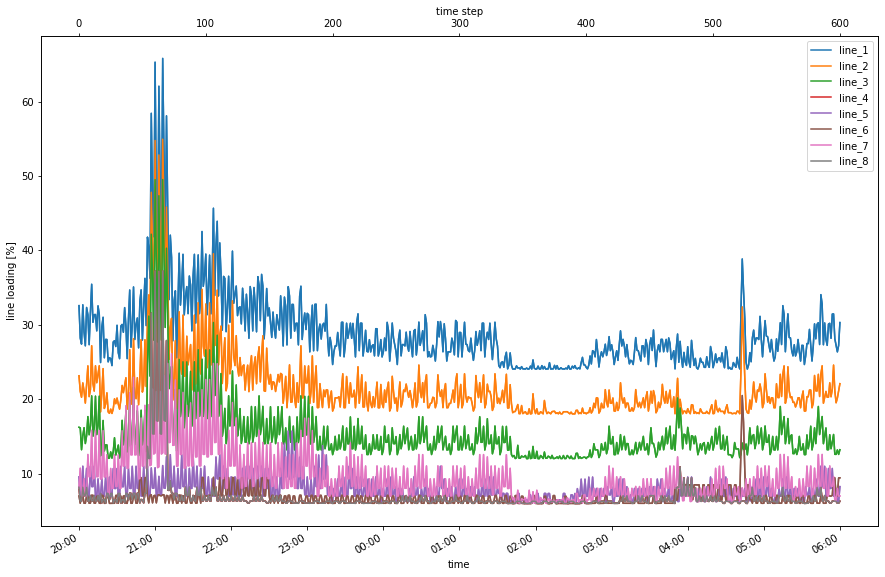

In [5]:
# run timeseries processes
nc = data_process_base.net_calc()

nc.four_loads_branched_make(night_mw)
nc.four_loads_branched_out("res_line", "loading_percent")
nc.four_loads_branched_run()
nc.four_loads_branched_read_loadpct()
nc.four_loads_branched_plot_linepct()

In [ ]:
def end_val_make(df):
    # append vals to end_val df
    pass

In [252]:
col_names = nc.ll.columns.tolist()
max_val = nc.ll.max()
max_val
# s.loc['line_1']

line_1    65.791764
line_2    54.945336
line_3    49.521215
line_4    37.244250
line_5    15.744529
line_6    20.508047
line_7    26.127799
line_8    37.244314
dtype: float64

In [233]:
end_val = pd.DataFrame(columns=col_names)
end_val.loc[0] = max_val
end_val


,line_1,line_2,line_3,line_4,line_5,line_6,line_7,line_8
0,65.791764,54.945336,49.521215,37.24425,15.744529,20.508047,26.127799,37.244314


In [250]:
max_ind = nc.ll.idxmax()
k = nc.night_mw.index.values[max_ind.tolist()]
max_time = pd.to_datetime(k).strftime('%H:%M:%S').tolist()
max_time

['19:06:00',
 '19:06:00',
 '19:06:00',
 '19:06:00',
 '20:45:00',
 '02:43:00',
 '19:13:00',
 '19:06:00']

In [251]:
end_time = pd.DataFrame(dtype='str', columns=col_names)
end_time.loc[0] = max_time
end_time

,line_1,line_2,line_3,line_4,line_5,line_6,line_7,line_8
0,19:06:00,19:06:00,19:06:00,19:06:00,20:45:00,02:43:00,19:13:00,19:06:00
